# Self-Driving Car Engineer Nanodegree

## Deep Learning


## Project: Build a Traffic Sign Recognition Classifier


* [Load the data](#LoadData)
* [Data Set Summary & Exploration](#SummaryExploration)
* [Design and Test a Model Architecture](#DesignTestModelArchitecture)
* [Select image reduction type](#ImageReduction)
* [Include an exploratory visualization of the dataset](#ExploratoryVisualization)
* [Images augmentation](#ImagesAugmentation)
* [Analyze of the architecture](#ArchitectureAnalyze)
    * [Basic functionality to describe a convolutional network with a dictionary](#ConvolutionalArchitectureDescription)
* [Train, Validate and Test the Model](#TrainValidateTest)
    * [Output Top 5 Softmax Probabilities For Each Image Found on the Web](#5TopSoftmax)
* [Visualize the Neural Network's State with Test Images](#VisualizeFeatureMaps)
    

---
## Load The Data <a name="LoadData"/>

In [1]:
# Load pickled data
import pickle
import csv

# TODO: Fill this in based on where you saved the training and testing data

training_file = "../Data/train.p"
validation_file = "../Data/valid.p"
testing_file = "../Data/test.p"
signnames_file = "signnames.csv"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(signnames_file, mode='r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    header_read = False
    signnames = {}
    for row in csv_reader:
        if header_read:
            signnames[int(row[0])] = row[1]
        header_read = True
        
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


---

### Data Set Summary & Exploration <a name="SummaryExploration"/>

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

#### Basic summary of the data set

In [2]:
import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]  # y_train.shape would be fine too

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_valid.shape[1], X_valid.shape[2])

# TODO: How many unique classes/labels there are in the dataset.
values, counts = np.unique(y_train, return_counts=True)
n_classes = len(values)


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


#### Exploratory visualization of the data set

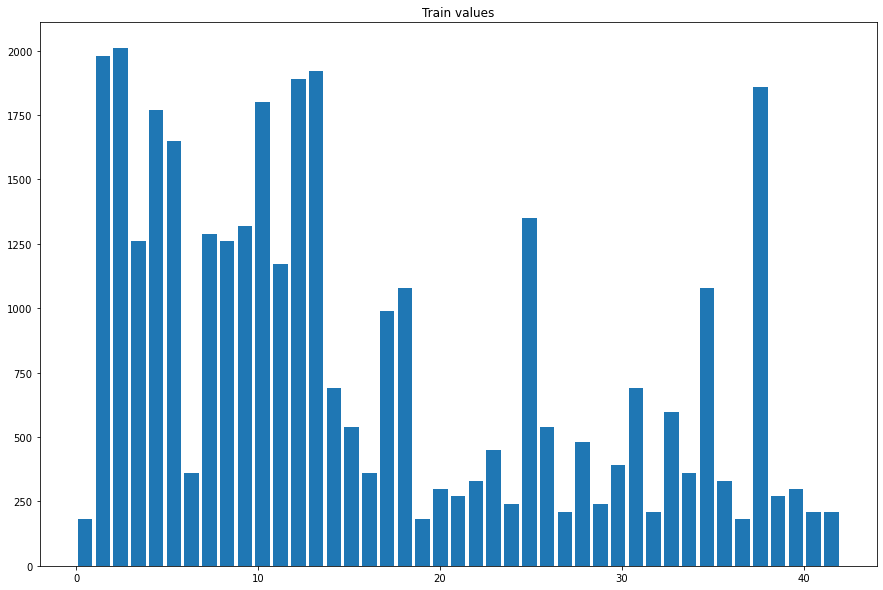

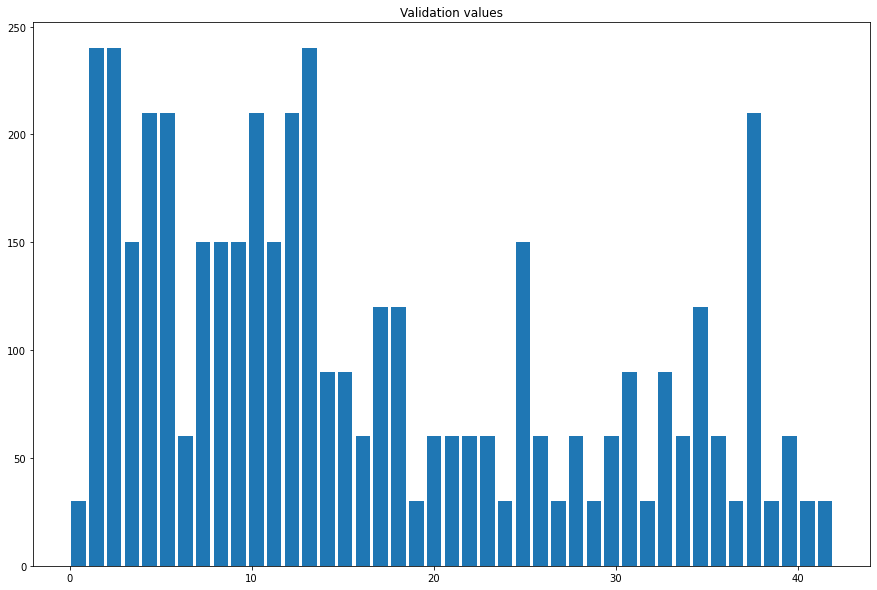

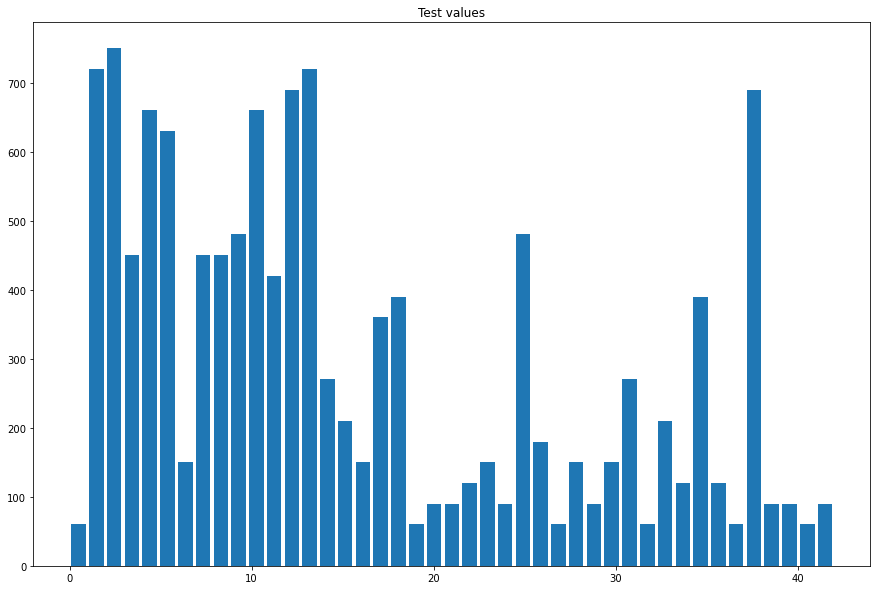

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing for vehicles over 3.5 metric tons', 11: 'Right-of-way at the next intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Vehicles over 3.5 metric tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve to the left', 20: 'Dangerous curve to the right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End of all speed and passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight o

In [3]:

import matplotlib.pyplot as plt
import random
import numpy as np# Visualizations will be shown in the notebook.
%matplotlib inline

# histogram of label frequency
def plot_histogram(y_values, title):
    fig, ax = plt.subplots()
    fig.set_size_inches((15, 10))
    hist, bins = np.histogram(y_values, bins=n_classes)
    center = (bins[:-1] + bins[1:]) / 2
    
    plt.bar(center, hist, align='center')
    plt.title(title)
    
    plt.show()
    
plot_histogram(y_train, "Train values")
plot_histogram(y_valid, "Validation values")
plot_histogram(y_test, "Test values")

print(signnames)

### Design and Test a Model Architecture <a name= "DesignTestModelArchitecture"/>
#### Convert to gray or y, Normalize, and Crop images

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def calculate_coords_resized(data_structure: [], n_elts: int):
    # 'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
    # 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around 
    # the sign in the image. THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS 
    # (32 by 32) OF THESE IMAGES
    data_structure['coords_resized'] = np.array([(
        int(data_structure['coords'][index][0]) * 32 // int(data_structure['sizes'][index][0]),
        int(data_structure['coords'][index][1]) * 32 // int(data_structure['sizes'][index][1]),
        int(data_structure['coords'][index][2]) * 32 // int(data_structure['sizes'][index][0]),
        int(data_structure['coords'][index][3]) * 32 // int(data_structure['sizes'][index][1]) ) for index in range(n_elts)])

def normalize_gray_images(data_structure, n_elts, want_crop = True):
    calculate_coords_resized(data_structure, n_elts)

    row, col = np.ogrid[:32, :32]
    data_structure['features_gray_cropped'] = []
    data_structure['normalized'] = []
    data_structure['reshaped'] = []
    for index in range(n_elts):
        mask = (col < data_structure['coords_resized'][index][0]) | (col > data_structure['coords_resized'][index][2]) | (row < data_structure['coords_resized'][index][1]) | (row > data_structure['coords_resized'][index][3])
    
        data_structure['features_gray_cropped'].append(np.copy(data_structure['features_gray'][index]))
        
        if want_crop:
            data_structure['features_gray_cropped'][index][mask] = 0
            
        mini, maxi = np.min(data_structure['features_gray_cropped'][index]), np.max(data_structure['features_gray_cropped'][index])
        normalized = (data_structure['features_gray_cropped'][index] - mini) / (maxi - mini) * 2 - 1
        normalized = normalized.reshape((32, 32, 1))
        
        data_structure['normalized'].append(normalized)

        

In [5]:
import cv2

def RGBToY(image):
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image_y = image_yuv[:,:,0]
    
    image_y = cv2.equalizeHist(image_y)
    
    mini, maxi = np.min(image_y), np.max(image_y)
    image_y = (image_y - mini) / (maxi - mini) * 2 - 1
    
    image_y = np.expand_dims(image_y, axis=2)
    
    return image_y

def normalize_y_images(data_structure, n_elts):
    calculate_coords_resized(data_structure, n_elts)

    data_structure['normalized'] = []

    for index in range(n_elts):
        data_structure['normalized'].append(RGBToY(data_structure['features'][index]))

### Select image reduction type <a name="ImageReduction"/>

In [6]:
use_y_instead_of_grayscale = True
use_cropped_images = False
use_augmented_images = True

if use_y_instead_of_grayscale:
    
    normalize_y_images(train, n_train)
    normalize_y_images(valid, n_validation)
    normalize_y_images(test, n_test)

else:
    train['features_gray'] = np.array([rgb2gray(train['features'][index]) for index in range(n_train)])
    valid['features_gray'] = np.array([rgb2gray(valid['features'][index]) for index in range(n_validation)])
    test['features_gray'] = np.array([rgb2gray(test['features'][index]) for index in range(n_test)])    

    normalize_gray_images(train, n_train, use_cropped_images)
    normalize_gray_images(valid, n_validation, use_cropped_images)
    normalize_gray_images(test, n_test, use_cropped_images)


X_train, y_train = train['normalized'], np.array(train['labels'])
X_valid, y_valid = valid['normalized'], np.array(valid['labels'])
X_test, y_test =   test['normalized'], np.array(test['labels'])


### Include an exploratory visualization of the dataset<a name="ExploratoryVisualization"/>

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [7]:

import matplotlib.pyplot as plt
import random
import numpy as np# Visualizations will be shown in the notebook.
%matplotlib inline


def plot_images(data_structure, show_nb_signs: int):
    for _ in range(show_nb_signs):
        index = random.randint(0, len(data_structure['features']) - 1)
        signname = signnames[data_structure['labels'][index]]
    
        fig = plt.figure()
    
        ax = fig.add_subplot(1, 2, 1)
        imgplot = plt.imshow(data_structure['features'][index])
        ax.set_title('%s\nColor' % signname)
    
        ax = fig.add_subplot(1, 2, 2)
        imgplot = plt.imshow(data_structure['normalized'][index].reshape(32, 32), cmap="gray")
        ax.set_title('%s\nNormalized' % signname)




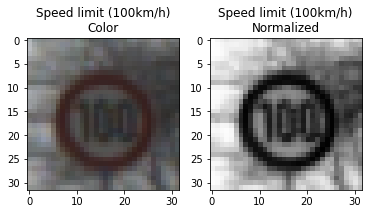

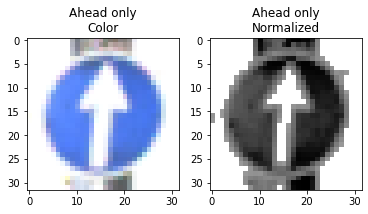

In [8]:
plot_images(train, 2)

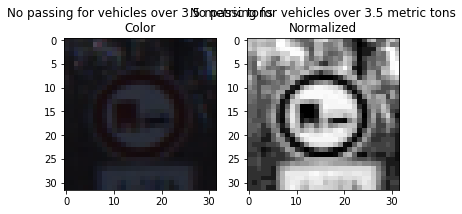

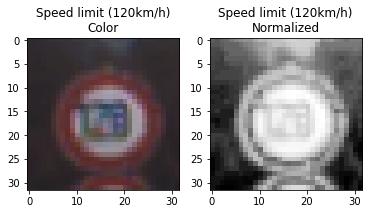

In [9]:
plot_images(test, 2)

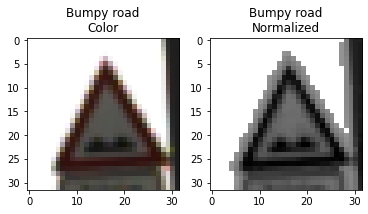

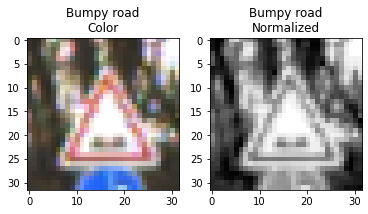

In [10]:
plot_images(valid, 2)

### Images augmentation <a name="ImagesAugmentation"/>

In [11]:
def dbg(s):
    print(s)
    print(train['normalized'].shape)
    print(train['normalized'][0].shape)
    print(train['normalized'][1].shape)
    print(train['normalized'][2].shape)
    print(train['normalized'][3].shape)
    

def normalize_image(image):
    mini, maxi = np.min(image), np.max(image)
    return (image - mini) / (maxi - mini) * 2 - 1

def translate(data_structure, index):
    x1, y1, x2, y2 = data_structure['coords_resized'][index]
    image = data_structure['normalized'][index]

    height, width = image.shape[:2]
    # create the translation matrix

    translation_matrix = np.float32([
        [1, 0, -int(x1 * np.random.random())],
        [0, 1, -int(y1 * np.random.random())]
    ])
    # apply translation
    final_size = (width, height)
    image_translated_left_top = cv2.warpAffine(
        image, translation_matrix, final_size
    )

    translation_matrix = np.float32([
        [1, 0, int((width-x2) * np.random.random())],
        [0, 1, int((height-y2) * np.random.random())]
    ])
    # apply translation
    final_size = (width, height)
    image_translated_right_bottom = cv2.warpAffine(
        image, translation_matrix, final_size
    )
 
    return [image_translated_left_top, image_translated_right_bottom]

def rotate(data_structure, index):

    image = data_structure['normalized'][index]
    height, width = image.shape[:2]
    
    rotated_images = []
    
    for angle in [-15, -5, 5, 15]:

        # get the rotation matrix
        rotation_matrix = cv2.getRotationMatrix2D(
            (width / 2, height / 2), angle, 1
        )
        # rotate the image
        rotated_image = cv2.warpAffine(
            image, rotation_matrix, (width, height)
        )
        
        rotated_images.append(rotated_image)
        
    return rotated_images

def filter_image(data_structure, index):

    blured_image = cv2.GaussianBlur(data_structure['normalized'][index],(5,5),0)
    
    return [blured_image]

def random_bright(data_structure, index):
    factor = 1 + np.random.random()
    brighter = data_structure['normalized'][index] * factor
    return [brighter]

def augment_images(data_structure, n_elts):
    added_images = 0
    nb_augmented = 0
    for index in range(n_elts):
        label_name = data_structure['labels'][index]
        
        augmented_images = translate(data_structure, index)
        augmented_images.extend(rotate(data_structure, index))
        augmented_images.extend(filter_image(data_structure, index))
        augmented_images.extend(random_bright(data_structure, index))
        augmented_images = [normalize_image(image).reshape(32, 32, 1) for image in augmented_images]        

        data_structure['normalized'].extend( augmented_images)
        nb_augmented = len(augmented_images)
        
        added_labels = [label_name for _ in range(nb_augmented)]
        
        data_structure['labels'] = np.append(data_structure['labels'], np.array(added_labels))
        added_images += nb_augmented
        
    return added_images, nb_augmented

if use_augmented_images:
    nb_train_added, nb_augmented = augment_images(train, n_train)

else:
    nb_train_added = 0
    nb_augmented = 0
    
old_n_train = n_train
n_train += nb_train_added

X_train, y_train = np.array(train['normalized']), np.array(train['labels'])

print("Created %d new train images" % (nb_train_added))
print(X_train.shape, y_train.shape)


Created 278392 new train images
(313191, 32, 32, 1) (313191,)


In [12]:
import matplotlib.pyplot as plt
import random
import numpy as np# Visualizations will be shown in the notebook.
%matplotlib inline


def plot_augmented_images(data_structure, show_nb_signs: int, from_index: int, nb_indexes: int, show_nb_images_in_a_row: int):
    titles = ["Tr left top", "Tr right bot", "Rotate 1", "Rotate 2", "Rotate 3", "Rotate 4", "Blur", "Brightness"]
    for _ in range(show_nb_signs):
        max_index = nb_indexes //show_nb_images_in_a_row
        index = random.randint(0, max_index) * show_nb_images_in_a_row
        
        signname = signnames[data_structure['labels'][index]]
    
        fig = plt.figure()
        fig.set_figheight(15)
        fig.set_figwidth(15)
        
        for nb_image in range(show_nb_images_in_a_row):
        
            ax = fig.add_subplot(show_nb_images_in_a_row // 2 + 1, show_nb_images_in_a_row // 2, nb_image + 1)
            imgplot = plt.imshow(data_structure['normalized'][index + nb_image].reshape(32, 32), cmap="gray")
            ax.set_title('%s\n%s' % (titles[nb_image], signname))


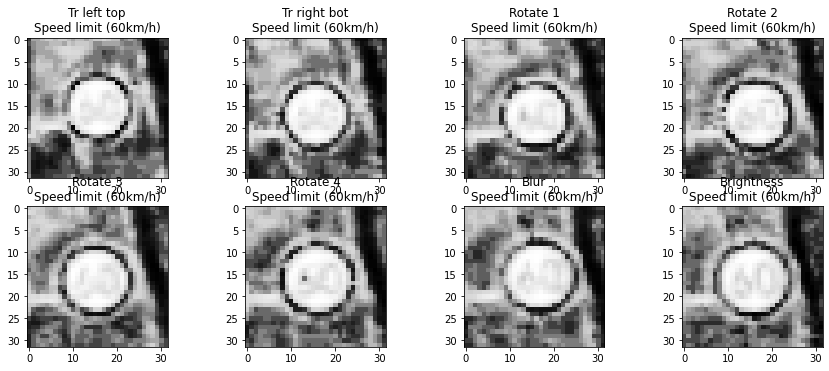

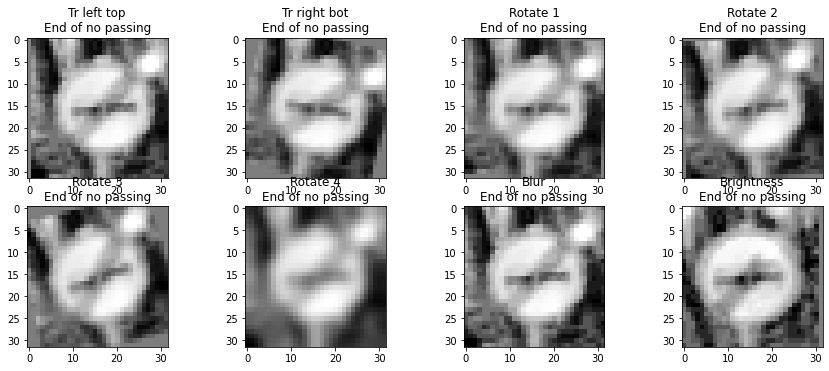

In [13]:
if use_augmented_images:
    plot_augmented_images(train, 2, old_n_train, nb_train_added, nb_augmented)

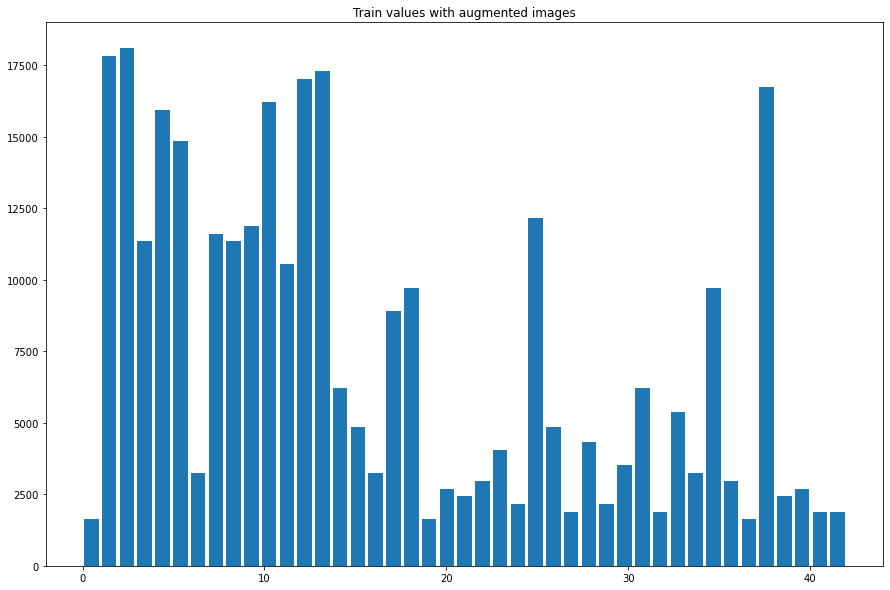

In [14]:
import matplotlib.pyplot as plt
import random
import numpy as np# Visualizations will be shown in the notebook.
%matplotlib inline

# histogram of label frequency
def plot_histogram(y_values, title):
    fig, ax = plt.subplots()
    fig.set_size_inches((15, 10))
    hist, bins = np.histogram(y_values, bins=n_classes)
    center = (bins[:-1] + bins[1:]) / 2
    
    plt.bar(center, hist, align='center')
    plt.title(title)
    
    plt.show()
    
if use_augmented_images:
    plot_histogram(y_train, "Train values with augmented images")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

See above: Convert to gray, Normalize, and Crop images

In [15]:
print(X_train.shape, y_train.shape)

(313191, 32, 32, 1) (313191,)


### Analyze of the architecture<a name ="ArchitectureAnalyze">

In [16]:
import tensorflow as tf
EPOCHS = 20
BATCH_SIZE = 256

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)




D:\Anaconda3\envs\IntroToTensorFlow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\IntroToTensorFlow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\IntroToTensorFlow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\IntroToTensorFlow\lib\site-packages\tensorflow\python\f

In [17]:
class HyperParameters:
    rate = 0.001
    mu = 0
    sigma = 0.1
    
    def set_rate(self, new_rate):   self.rate = new_rate        
    def get_rate(self):             return self.rate
    def set_mu(self, new_mu):       self.mu = new_mu       
    def get_mu(self):               return self.mu
    def set_sigma(self, new_sigma): self.sigma = new_sigma       
    def get_sigma(self):            return self.sigma
    def set_sigma(self, new_sigma): self.sigma = new_sigma       
    def get_sigma(self):            return self.sigma
    def set_architecture(self, new_architecture): self.architecture = new_architecture       
    def get_architecture(self):                   return self.architecture
    def set_placeholders(self, values):          self.values = values
    def get_placeholders(self):                  return self.values
    
hyper_parameters = HyperParameters()

#### Basic functionality to describe a convolutional network with a dictionary<a name ="ConvolutionalArchitectureDescription"/>

In [18]:
from tensorflow.contrib.layers import flatten
import re

def conv2d(x, W, b, strides=1):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    return x

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')


def LeNet(x):
    mu = hyper_parameters.get_mu()
    sigma = hyper_parameters.get_sigma()
    architecture = hyper_parameters.get_architecture()
    _, _, keep_prob = hyper_parameters.get_placeholders()
        
    weights = {}
    biases = {}
    
    print(architecture['convo_nn_size'])
   
    for key in architecture['convo_nn_size']:
        print("Setting up: ", key, architecture['convo_nn_size'][key], architecture['convo_nn_size'][key][-1])
        name_weight = 'weights-' + key
        name_biases = 'biases-' + key
        print("name_weight: ", name_weight)
        print("name_biases: ", name_biases)
        weights[key] = tf.Variable(tf.truncated_normal(architecture['convo_nn_size'][key], mean = mu, stddev = sigma, name = name_weight))
        biases[key] = tf.Variable(tf.zeros([architecture['convo_nn_size'][key][-1]]), name = name_biases)

    convo_reference = {'x': x}
    for input_name, output_name in architecture['links_convo']:
        input_val = convo_reference[input_name]
        m = re.search('maxpool-(\d+)-\w+', output_name)
        if m:
            size_max_pool_layer = int(m.group(1))
            convo_reference[output_name] =  maxpool2d(input_val, k = size_max_pool_layer)

            print("%s maxpool2d --> %s" % (input_name, output_name))
            
        else:
            convo_reference[output_name] = conv2d(input_val, weights[output_name], biases[output_name])   
            print("%s conv2d --> %s" % (input_name, output_name))

        print(convo_reference[output_name].shape)
        
    nn_reference = {}
    convos_to_nn = architecture['links_convo_nn']
   
    fc0 = tf.concat([tf.contrib.layers.flatten(convo_reference[key]) for key in convos_to_nn[:-1]], axis=1)
    nn_name = convos_to_nn[-1]                                         
    fc1 = tf.add(tf.matmul(fc0, weights[nn_name]), biases[nn_name])
    fc1 = tf.nn.relu(fc1)
    nn_reference[nn_name] = tf.nn.dropout(fc1, keep_prob)
    print("Inception: %s linked to --> %s" % (convos_to_nn[:-1], convos_to_nn[-1]))
    print(nn_reference[nn_name].shape)
    
                                                           
    
    for input_name, output_name in architecture['links_nn']:
        fc1 = tf.add(tf.matmul(nn_reference[input_name], weights[output_name]), biases[output_name])
        if output_name != architecture['out_name']:
            fc1 = tf.nn.relu(fc1)
            fc1 = tf.nn.dropout(fc1, keep_prob)                                              
        print("NN: %s linked to --> %s" % (input_name, output_name))
        print(fc1.shape)
        nn_reference[output_name] = fc1                                              
    return nn_reference[architecture['out_name']], convo_reference, convos_to_nn
    



In [19]:
architectures = {
    
    '3x3o5x5,3x3o,4x4,2nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [3, 3, 1, 12] , 
            'wc12': [3, 3, 12, 24], 
    
            'wc21': [5, 5, 24, 48], 
            'wc22': [5, 5, 48, 96],
            
            'wc31': [4, 4, 1, 12], 

            'wd1':  [7920, 500]   , 
            'wd2':  [500, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22'], ['x', 'wc31'], ['wc31', 'maxpool-2-wc31']],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'maxpool-2-wc31', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'out']]
    },

    '3x3o5x5,3x3o,4x4,2x2,2nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [3, 3, 1, 12] , 
            'wc12': [3, 3, 12, 24], 
    
            'wc21': [5, 5, 24, 48], 
            'wc22': [5, 5, 48, 96],
            
            'wc31': [4, 4, 1, 12], 

            'wc41': [2, 2, 1, 8], 
            
            'wd1':  [7920, 500]   , 
            'wd2':  [500, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], 
                        ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22'], 
                        ['x', 'wc31'], ['wc31', 'maxpool-2-wc31'],
                        ['x', 'wc41'], ['wc41', 'maxpool-2-wc41'],
                       ],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'maxpool-2-wc31', 'maxpool-2-wc41', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'out']]
    },

    '4x4o5x5,4x4o,4x4,3x3,3nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [4, 4, 1, 12] , 
            'wc12': [4, 4, 12, 24], 
    
            'wc21': [5, 5, 24, 48], 
            'wc22': [5, 5, 48, 96],
            
            'wc31': [4, 4, 1, 24], 

            'wc41': [3, 3, 1, 12], 

            'wd1':  [11844, 5000]   , 
            'wd2':  [5000, 1000]    , 
            'wd3':  [1000, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], 
                        ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22'], 
                        ['x', 'wc31'], ['wc31', 'maxpool-2-wc31'],
                        ['x', 'wc41'], ['wc41', 'maxpool-2-wc41'],
                       ],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'maxpool-2-wc31', 'maxpool-2-wc41', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'wd3'], ['wd3', 'out']]
    },

    '4x4o5x5,4x4o,4x4,3x3,2nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [4, 4, 1, 12] , 
            'wc12': [4, 4, 12, 24], 
    
            'wc21': [5, 5, 24, 48], 
            'wc22': [5, 5, 48, 96],
            
            'wc31': [4, 4, 1, 24], 

            'wc41': [3, 3, 1, 12], 

            'wd1':  [11844, 500]   , 
            'wd2':  [500, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], 
                        ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22'], 
                        ['x', 'wc31'], ['wc31', 'maxpool-2-wc31'],
                        ['x', 'wc41'], ['wc41', 'maxpool-2-wc41'],
                       ],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'maxpool-2-wc31', 'maxpool-2-wc41', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'out']]
    },

    '4x4o5x5,4x4o,4x4,2nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [4, 4, 1, 12] , 
            'wc12': [4, 4, 12, 24], 
    
            'wc21': [5, 5, 24, 48], 
            'wc22': [5, 5, 48, 96],
            
            'wc31': [4, 4, 1, 24], 

            'wd1':  [9144, 500]   , 
            'wd2':  [500, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], 
                        ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22'], 
                        ['x', 'wc31'], ['wc31', 'maxpool-2-wc31']
                       ],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'maxpool-2-wc31', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'out']]
    },

    '3x3o4x4,3x3o,3x3,2nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [3, 3, 1, 12] , 
            'wc12': [3, 3, 12, 24], 
    
            'wc21': [4, 4, 24, 48], 
            'wc22': [4, 4, 48, 96],
            
            'wc31': [3, 3, 1, 12], 

            'wd1':  [8940, 500]   , 
            'wd2':  [500, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22'], ['x', 'wc31'], ['wc31', 'maxpool-2-wc31']],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'maxpool-2-wc31', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'out']]
    },

    '3x3o4x4,3x3o,3x3,3nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [3, 3, 1, 12] , 
            'wc12': [3, 3, 12, 24], 
    
            'wc21': [4, 4, 24, 48], 
            'wc22': [4, 4, 48, 96],
            
            'wc31': [3, 3, 1, 12], 

            'wd1':  [8940, 500]   , 
            'wd2':  [500, 300]    , 
            'wd3':  [300, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], 
                        ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22'], 
                        ['x', 'wc31'], ['wc31', 'maxpool-2-wc31']],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'maxpool-2-wc31', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'wd3'], ['wd3', 'out']]
    },

    '3x3o5x5,3x3o,3x3,2nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [3, 3, 1, 12] , 
            'wc12': [3, 3, 12, 24], 
    
            'wc21': [5, 5, 24, 48], 
            'wc22': [5, 5, 48, 96],
            
            'wc31': [3, 3, 1, 12], 

            'wd1':  [8268, 500]   , 
            'wd2':  [500, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22'], ['x', 'wc31'], ['wc31', 'maxpool-2-wc31']],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'maxpool-2-wc31', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'out']]
    },

    '3x3o4x4,3x3o,2nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [3, 3, 1, 12] , 
            'wc12': [3, 3, 12, 24], 
    
            'wc21': [4, 4, 24, 48], 
            'wc22': [4, 4, 48, 96],
            
            'wd1':  [6240, 500]   , 
            'wd2':  [500, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], 
                        ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22'] 
                       ],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'out']]
    },


    '3x3-5x5,3x3o,2nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [3, 3, 1, 12] , 
            'wc12': [3, 3, 12, 24], 
    
            'wc21': [5, 5, 24, 48], 
            'wc22': [5, 5, 48, 96],
            
            'wd1':  [5568, 500]   , 
            'wd2':  [500, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22']],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'out']]
    },

    '3x3-6x6,3x3o,2nn': {
        'out_name': 'out',
        'convo_nn_size': {
            'wc11': [3, 3, 1, 12] , 
            'wc12': [3, 3, 12, 24], 
    
            'wc21': [6, 6, 24, 48], 
            'wc22': [6, 6, 48, 96],
            
            'wd1':  [5088, 500]   , 
            'wd2':  [500, 200]    , 
    
            'out': [200, 43]
        },
        
        'links_convo': [['x', 'wc11'], ['wc11', 'wc12'], ['wc12', 'maxpool-2-wc12'], ['maxpool-2-wc12', 'wc21'], ['wc21', 'wc22'], ['wc22', 'maxpool-2-wc22']],
        'links_convo_nn': ['maxpool-2-wc12', 'maxpool-2-wc22', 'wd1'],
        'links_nn': [['wd1', 'wd2'], ['wd2', 'out']]
    }

    
}

In [20]:

#def setup_optimizer():

architecture_name = '3x3o4x4,3x3o,3x3,3nn' #'3x3o5x5,3x3o,4x4,2x2,2nn'
print("Starting architecture: %s" % architecture_name)
hyper_parameters.set_architecture(architectures[architecture_name])


x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

hyper_parameters.set_placeholders((x, y, keep_prob))

logits, convo_reference, convos_to_nn = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = hyper_parameters.get_rate())
training_operation = optimizer.minimize(loss_operation)
    
#    return logits, training_operation, x, y, keep_prob, one_hot_y

Starting architecture: 3x3o4x4,3x3o,3x3,3nn
{'wc11': [3, 3, 1, 12], 'wc12': [3, 3, 12, 24], 'wc21': [4, 4, 24, 48], 'wc22': [4, 4, 48, 96], 'wc31': [3, 3, 1, 12], 'wd1': [8940, 500], 'wd2': [500, 300], 'wd3': [300, 200], 'out': [200, 43]}
Setting up:  wc11 [3, 3, 1, 12] 12
name_weight:  weights-wc11
name_biases:  biases-wc11
Setting up:  wc12 [3, 3, 12, 24] 24
name_weight:  weights-wc12
name_biases:  biases-wc12
Setting up:  wc21 [4, 4, 24, 48] 48
name_weight:  weights-wc21
name_biases:  biases-wc21
Setting up:  wc22 [4, 4, 48, 96] 96
name_weight:  weights-wc22
name_biases:  biases-wc22
Setting up:  wc31 [3, 3, 1, 12] 12
name_weight:  weights-wc31
name_biases:  biases-wc31
Setting up:  wd1 [8940, 500] 500
name_weight:  weights-wd1
name_biases:  biases-wd1
Setting up:  wd2 [500, 300] 300
name_weight:  weights-wd2
name_biases:  biases-wd2
Setting up:  wd3 [300, 200] 200
name_weight:  weights-wd3
name_biases:  biases-wd3
Setting up:  out [200, 43] 43
name_weight:  weights-out
name_biases:

In [21]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, accuracy_operation):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


### Train, Validate and Test the Model<a name = "TrainValidateTest"/>


In [22]:
import time


print("Training...")
print()

filename = "out-" + architecture_name + ".log"

#saver, training_operation, accuracy_operation, x, y, keep_prob, one_hot_y = setup_prediction_pipeline()
max_accuracy = 0
for keep_prob_val in [0.65]:#, 0.5, 0.55]:
    for rate in [0.001]:
        hyper_parameters.set_rate(rate)
        for mu in [0.1]:
            hyper_parameters.set_mu(mu)
            for sigma in [0]:
                hyper_parameters.set_sigma(sigma)
                
                print("keep_prob: %f, rate: %f, mu: %f, sigma: %f\n" % (keep_prob_val, hyper_parameters.get_rate(), hyper_parameters.get_mu(), hyper_parameters.get_sigma()))
                with tf.Session() as sess:
                    sess.run(tf.global_variables_initializer())
                    num_examples = len(X_train)

                    start_session = time.time()
                    for i in range(EPOCHS):
                        start_epoch = time.time()
                        X_train, y_train = shuffle(X_train, y_train)
                        for offset in range(0, num_examples, BATCH_SIZE):
                            end = offset + BATCH_SIZE
                            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob_val})

                        end_epoch = time.time()                          
                            
                        validation_accuracy = evaluate(X_valid, y_valid, accuracy_operation)
                        print("EPOCH {} ...".format(i+1))
                        print("Validation Accuracy = {:.3f}".format(validation_accuracy))

                        with open(filename, 'a') as f:
                            f.write("  keep_prob: %f, rate: %f, mu: %f, sigma: %f\n" % (keep_prob_val, hyper_parameters.get_rate(), hyper_parameters.get_mu(), hyper_parameters.get_sigma()))
                            f.write("  Epoch %d run in %s accuracy = %f \n" % (i+1, end_epoch-start_epoch, validation_accuracy))
                        if max_accuracy < validation_accuracy:
                            saver.save(sess, './trafficsign.ckpt')
                            max_accuracy = validation_accuracy
                            print("Model saved with for maximum accuracy {:.3f}".format(validation_accuracy))
                        print("Elapsed time: %s\n" % (end_epoch-start_epoch))
                    end_session = time.time()
                    
                    with open(filename, 'a') as f:
                        f.write("accuracy: %f  --  keep_prob: %f, rate: %f, mu: %f, sigma: %f done in %s\n" % (validation_accuracy, keep_prob_val, hyper_parameters.get_rate(), hyper_parameters.get_mu(), hyper_parameters.get_sigma(), end_session-start_session))
                        


Training...

keep_prob: 0.650000, rate: 0.001000, mu: 0.100000, sigma: 0.000000

EPOCH 1 ...
Validation Accuracy = 0.985
Model saved with for maximum accuracy 0.985
Elapsed time: 799.2579386234283

EPOCH 2 ...
Validation Accuracy = 0.987
Model saved with for maximum accuracy 0.987
Elapsed time: 874.6444382667542

EPOCH 3 ...
Validation Accuracy = 0.992
Model saved with for maximum accuracy 0.992
Elapsed time: 811.1483614444733

EPOCH 4 ...
Validation Accuracy = 0.991
Elapsed time: 810.7084455490112

EPOCH 5 ...
Validation Accuracy = 0.989
Elapsed time: 873.6780760288239

EPOCH 6 ...
Validation Accuracy = 0.993
Model saved with for maximum accuracy 0.993
Elapsed time: 742.0212275981903

EPOCH 7 ...
Validation Accuracy = 0.995
Model saved with for maximum accuracy 0.995
Elapsed time: 781.5490605831146

EPOCH 8 ...
Validation Accuracy = 0.990
Elapsed time: 731.0899684429169

EPOCH 9 ...
Validation Accuracy = 0.995
Model saved with for maximum accuracy 0.995
Elapsed time: 746.9457292556763

In [23]:
 with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
    saver.restore(sess, "./trafficsign.ckpt")
    
    validation_accuracy_test = evaluate(X_test, y_test, accuracy_operation)
    print("Validation Accuracy for test data set = {:.3f}".format(validation_accuracy_test))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
Validation Accuracy for test data set = 0.981


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

---

## Test a Model on New Images <a name = "TestModelNewImages">

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [24]:
import cv2
import numpy as np

web = {'features': [], 'coords': [(0, 0, 31, 31), (0, 0, 31, 31), (0, 0, 31, 31), (0, 0, 31, 31), (0, 0, 31, 31)],
        'sizes': [(32, 32), (32, 32), (32, 32), (32, 32), (32, 32)], 'labels': [1, 2, 10, 12, 13]}
n_web = 5
for image_name in ["newimage-30kmh.png", "newimage-50kmh.png", "newimage-nopassing3.5t.png", "newimage-priority.png", "newimage-yield.png"]:
    img = cv2.imread(image_name)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    web['features'].append(img)
    



In [25]:
if use_y_instead_of_grayscale:
    
    normalize_y_images(web, n_web)
    normalize_y_images(valid, n_validation)
    normalize_y_images(test, n_test)
  
else:
    web['features_gray'] = np.array([rgb2gray(web['features'][index]).reshape(32, 32, 1) for index in range(n_web)])

    normalize_gray_images(web, n_web, False)                      

            
 
X_web, y_web = np.array(web['normalized']), np.array(web['labels'])



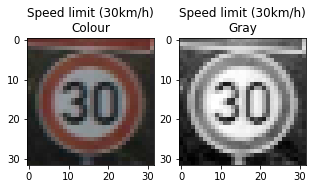

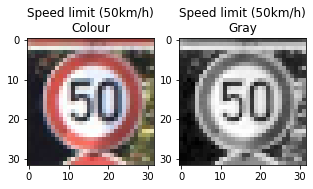

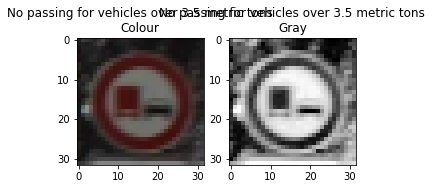

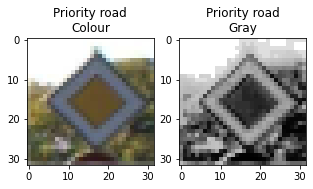

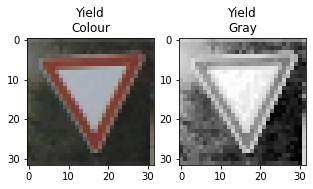

In [26]:

for index in range(len(web['normalized'])):
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(5)
        
    signname = signnames[web['labels'][index]]

    ax = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(web['features'][index])
    ax.set_title('%s\nColour' % (signname))
    
    ax = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(web['normalized'][index].reshape(32, 32), cmap="gray")
    ax.set_title('%s\nGray' % (signname))

        
    


### Predict the Sign Type for Each Image

In [27]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
    saver.restore(sess, "./trafficsign.ckpt")
    web_accuracy = evaluate(X_web, y_web, accuracy_operation)
    print("Accuracy from images from the Web = {:.2f}".format(web_accuracy))

INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
Accuracy from images from the Web = 1.00


Accuracy is 100%

### Output Top 5 Softmax Probabilities For Each Image Found on the Web<a name = "5TopSoftmax"/>

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [28]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
    saver.restore(sess, "./trafficsign.ckpt")
    softmax_logits = sess.run(softmax_logits, feed_dict={x: web['normalized'], keep_prob: 1.0})
    top_k = sess.run(top_k, feed_dict={x: web['normalized'], keep_prob: 1.0})
    


INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt


In [29]:


for index in range(len(top_k.indices)):
    top5 = top_k.indices[index]
    values = top_k.values[index]
    for subindex in range(len(top5)):
        print("%s: %.6f %%" % (signnames[top5[subindex]], values[subindex] * 100))
    print("\n")

Speed limit (30km/h): 100.000000 %
Speed limit (50km/h): 0.000000 %
Speed limit (70km/h): 0.000000 %
Speed limit (20km/h): 0.000000 %
Speed limit (60km/h): 0.000000 %


Speed limit (50km/h): 100.000000 %
Speed limit (30km/h): 0.000000 %
Speed limit (80km/h): 0.000000 %
Speed limit (20km/h): 0.000000 %
Speed limit (60km/h): 0.000000 %


No passing for vehicles over 3.5 metric tons: 100.000000 %
Speed limit (20km/h): 0.000000 %
Speed limit (30km/h): 0.000000 %
Speed limit (50km/h): 0.000000 %
Speed limit (60km/h): 0.000000 %


Priority road: 100.000000 %
Speed limit (20km/h): 0.000000 %
Speed limit (30km/h): 0.000000 %
Speed limit (50km/h): 0.000000 %
Speed limit (60km/h): 0.000000 %


Yield: 100.000000 %
Speed limit (20km/h): 0.000000 %
Speed limit (30km/h): 0.000000 %
Speed limit (50km/h): 0.000000 %
Speed limit (60km/h): 0.000000 %




### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Visualize the Neural Network's State with Test Images<a name = "VisualizeFeatureMaps"/>

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [30]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1, title = 'No title'):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap) + "\n" + title) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [38]:
random_index = int(np.random.random() * X_web.shape[0])
random_image = np.expand_dims(X_web[random_index], axis=0)

all_convo_keys = list(convo_reference.keys())
print(all_convo_keys)
index_all_convo_keys = 0

['x', 'wc11', 'wc12', 'maxpool-2-wc12', 'wc21', 'wc22', 'maxpool-2-wc22', 'wc31', 'maxpool-2-wc31']


INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
key:x


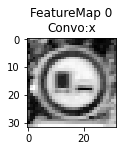

In [39]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
key:wc11


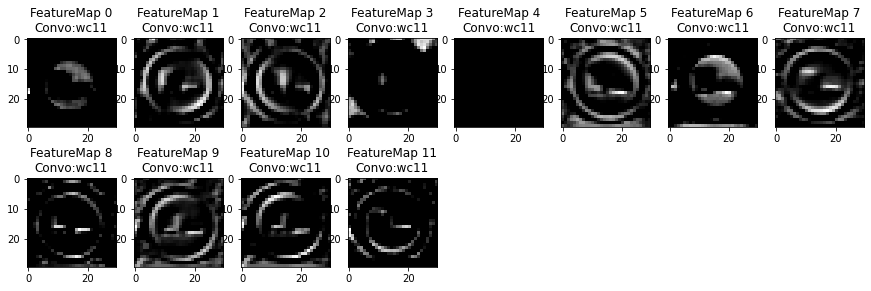

In [40]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
key:wc12


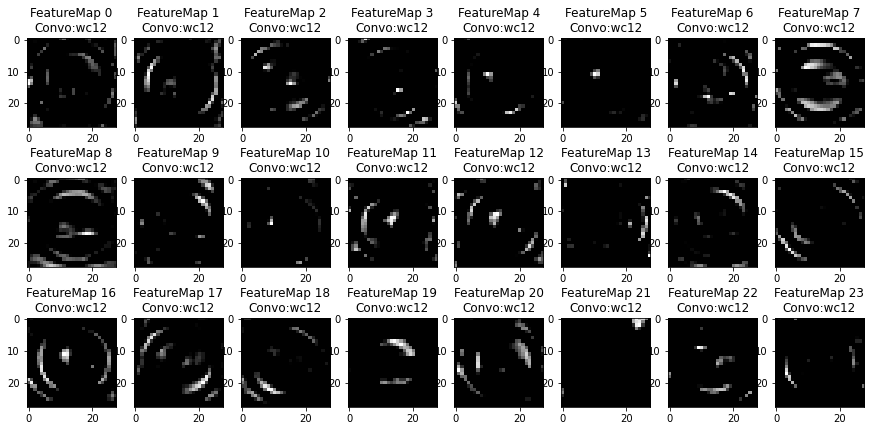

In [41]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
key:maxpool-2-wc12


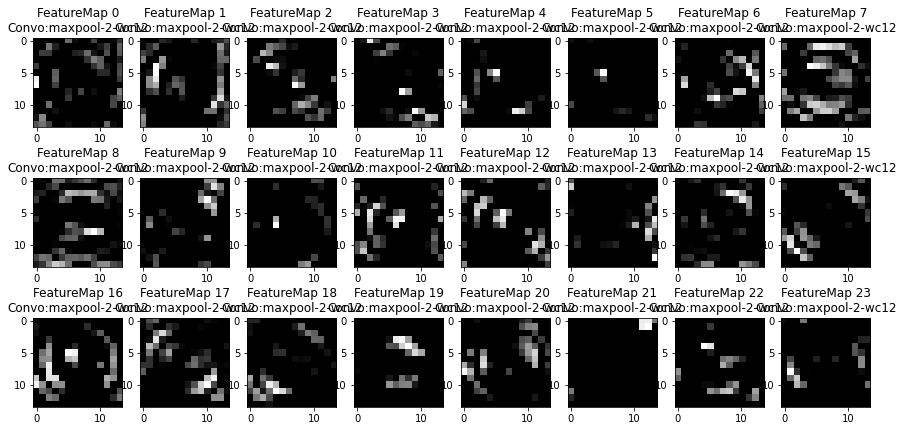

In [42]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
key:wc21


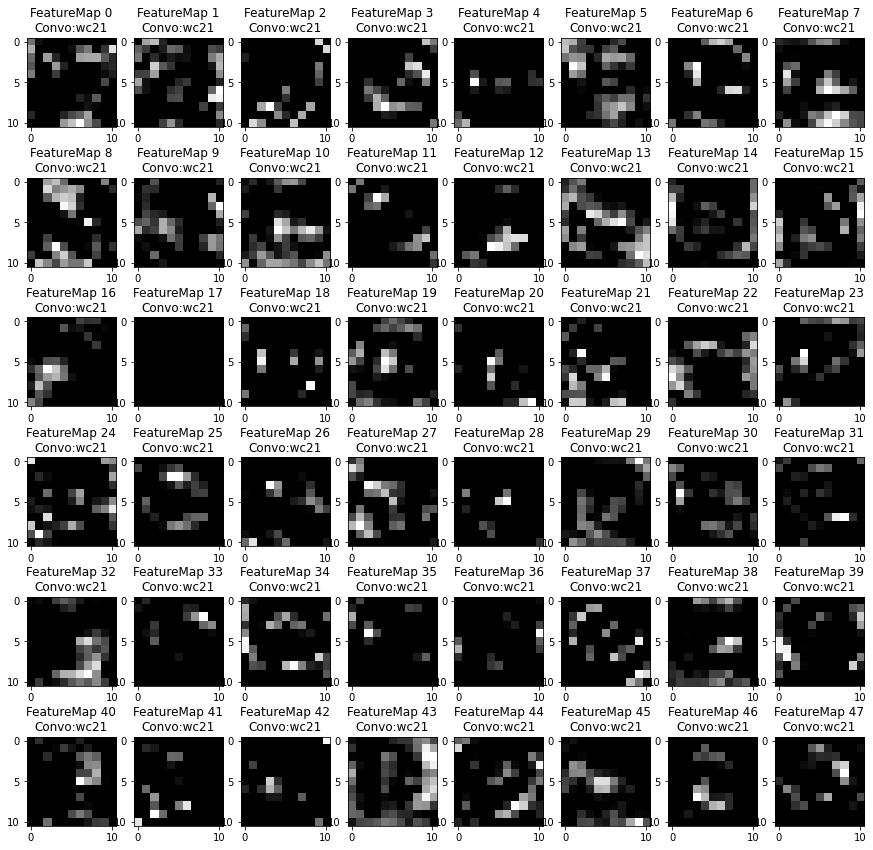

In [43]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
key:wc22


ValueError: num must be 1 <= num <= 48, not 49

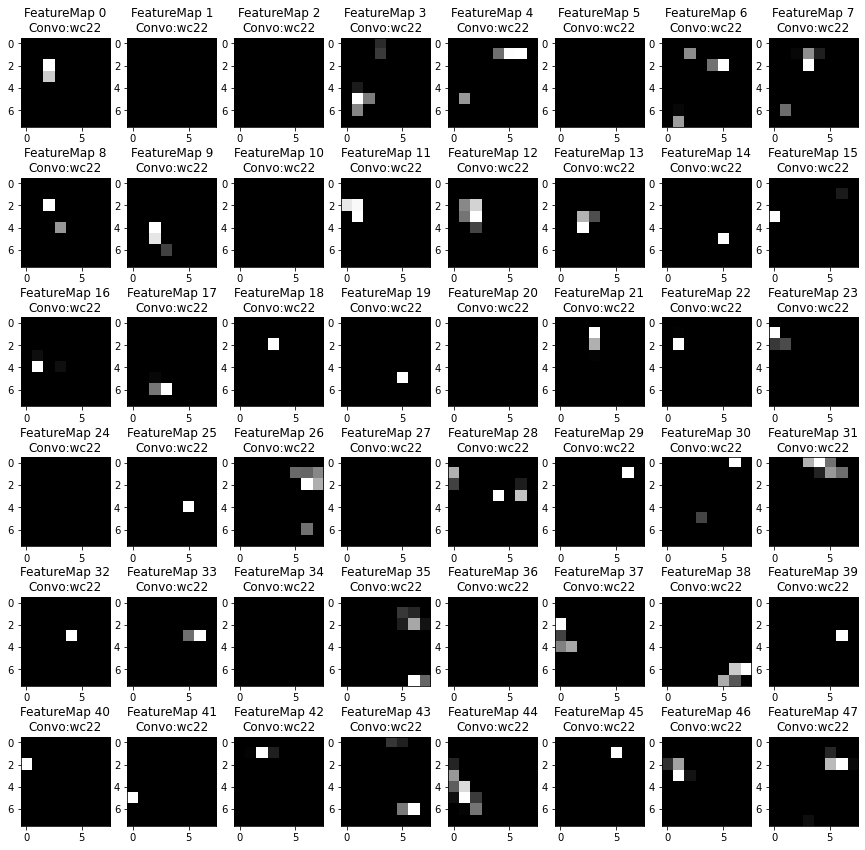

In [44]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
key:maxpool-2-wc22


ValueError: num must be 1 <= num <= 48, not 49

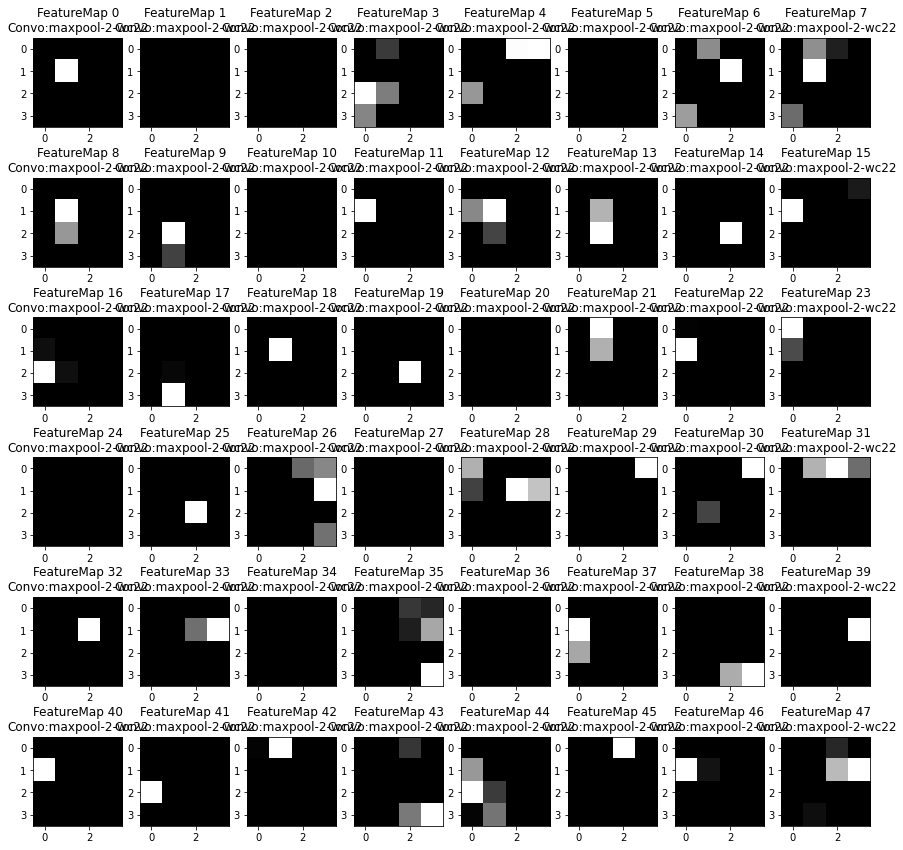

In [45]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
key:wc31


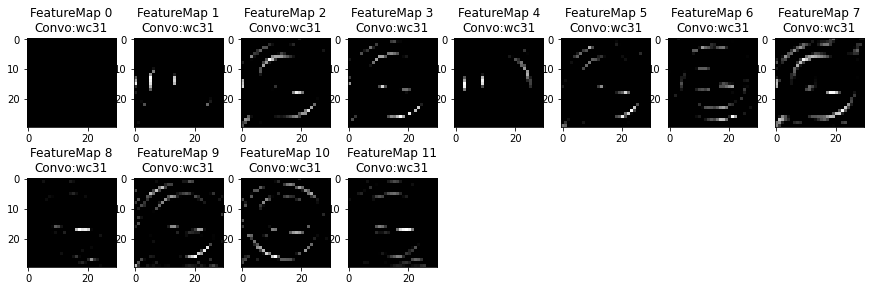

In [46]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

INFO:tensorflow:Restoring parameters from ./trafficsign.ckpt
key:maxpool-2-wc31


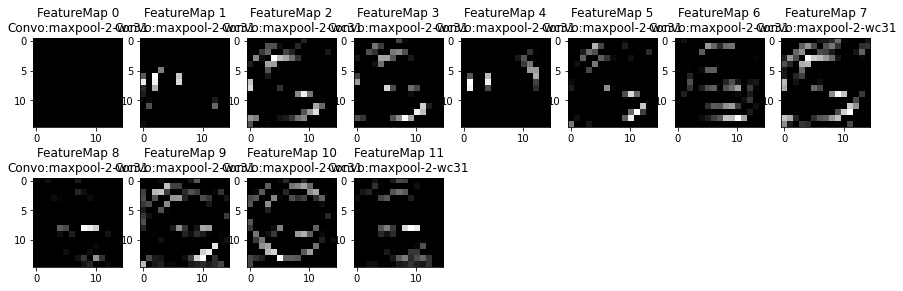

In [47]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

In [48]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

No more convolutional stage to show


In [49]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")

No more convolutional stage to show


In [ ]:
if index_all_convo_keys < len(all_convo_keys):
    convo = all_convo_keys[index_all_convo_keys]
    index_all_convo_keys += 1    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph('./trafficsign.ckpt.meta')
        saver.restore(sess, "./trafficsign.ckpt")
    
        print('key:' + convo)
        outputFeatureMap(random_image, convo_reference[convo], plt_num=1, title = "Convo:" + convo)

else:
    print("No more convolutional stage to show")